# Surface heat balance in cold traps during the spin-up phase

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
from tqdm.notebook import tqdm

In [3]:
import cartopy.crs as ccrs
import iris
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from cmcrameri import cm
from matplotlib.offsetbox import AnchoredText

In [4]:
import iris.plot as iplt
import iris.quickplot as qplt
from ipywidgets import interact
from iris.analysis.maths import apply_ufunc

In [5]:
# My packages and local scripts
from aeolus.calc import (
    abs_coord_mean,
    d_dz,
    deriv,
    dry_lapse_rate,
    integrate,
    last_n_day_mean,
    meridional_mass_streamfunction,
    meridional_mean,
    precip_sum,
    spatial,
    spatial_mean,
    superrotation_index,
    time_mean,
    toa_cloud_radiative_effect,
    vertical_mean,
    water_path,
    zonal_mean,
)
from aeolus.const import add_planet_conf_to_cubes, init_const
from aeolus.coord import (
    coord_to_cube,
    get_cube_rel_days,
    get_xy_coords,
    interp_cube_from_height_to_pressure_levels,
    interp_cubelist_from_height_to_pressure_levels,
    isel,
    roll_cube_pm180,
)
from aeolus.core import AtmoSim
from aeolus.io import load_data, save_cubelist
from aeolus.meta import const_from_attrs, update_metadata
from aeolus.model import um, um_stash
from aeolus.plot import (
    add_custom_legend,
    fmt_lonlat,
    label_global_map_gridlines,
    subplot_label_generator,
    tex2cf_units,
)
from aeolus.region import Region
from aeolus.subset import DimConstr, extract_last_n_days, l_range_constr

In [6]:
import mypaths
from pouch.clim_diag import (
    KURTOSIS,
    calc_derived_cubes,
    d_dphi,
    last_500d,
    latent_heating_rate,
    rolling_mean,
)
from pouch.path import lsdir
from pouch.plot import (
    KW_AUX_TTL,
    KW_AXGR,
    KW_CART,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    KW_SYM0,
    XLOCS,
    YLOCS,
    add_aux_yticks,
    draw_scalar_cube,
    draw_vector_cubes,
    figsave,
    linspace_pm1,
    make_map_figure,
    use_style,
)

In [7]:
from commons import (
    DAYSIDE,
    GLM_MODEL_TIMESTEP,
    GLM_SUITE_ID,
    NIGHTSIDE,
    SIM_LABELS,
    cold_traps,
)

In [8]:
use_style()

In [9]:
img_prefix = f"{GLM_SUITE_ID}_spinup"
inp_dir = mypaths.sadir / f"{GLM_SUITE_ID}_spinup"
time_prof = "mean_days0_499"
plotdir = mypaths.plotdir / img_prefix

In [10]:
# Load processed data
runs = {}
for sim_label, sim_prop in tqdm(SIM_LABELS.items()):
    planet = sim_prop["planet"]
    const = init_const(planet, directory=mypaths.constdir)

    cl = load_data(
        files=inp_dir / f"{GLM_SUITE_ID}_{sim_label}_raddiag.nc",
    )
    cl = iris.cube.CubeList([roll_cube_pm180(cube) for cube in cl])
    lw_up_forcing = cl.extract_cube(um_stash.lw_up_forcing)
    lw_up_forcing.rename(um.lw_up_forcing)
    lw_up_forcing.units = cl.extract_cube(um.lw_up).units
    lw_dn_forcing = cl.extract_cube(um_stash.lw_dn_forcing)
    lw_dn_forcing.rename(um.lw_dn_forcing)
    lw_dn_forcing.units = cl.extract_cube(um.lw_dn).units
    cl += load_data(
        files=inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}.nc",
    )
    cldtop = cl.extract_cube("m01s09i223")
    cldtop.rename("total_cloud_top_height")
    cldtop.units = "kft"

    add_planet_conf_to_cubes(cl, const)
    # Derive additional fields
    calc_derived_cubes(cl, const=const, model=um)
    # Use the cube list to initialise an AtmoSim object
    runs[sim_label] = AtmoSim(
        cl,
        name=sim_label,
        planet=planet,
        const_dir=mypaths.constdir,
        timestep=cl[-1].attributes["timestep"],
        model=um,
        vert_coord="z",
    )

  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
# def temperature_at_cloud_top(AS, model=um):
#     import xarray as xr

#     cldtop = AS._cubes.extract_cube("m01s09i223")
#     cldtop.convert_units("m")
#     cldtop_xr = xr.DataArray.from_iris(cldtop)
#     temp_at_cldtop_xr = xr.DataArray.from_iris(AS.temp).sel(
#         {model.z: cldtop_xr}, method="nearest"
#     )
#     return temp_at_cldtop_xr.where(cldtop_xr > 0, np.nan).to_iris()


# def cloud_top_height_masked(AS, model=um):
#     cldtop = AS._cubes.extract_cube("m01s09i223").copy()
#     cldtop_m = iris.util.mask_cube(cldtop, cldtop.core_data() < 0)
#     return cldtop_m

In [12]:
from math import prod


@update_metadata(units="kg m-2")
def sum_cwp_ccp_rwp(cubes):
    # cwp = water_path(cubes, kind="cloud_water")
    cwp = 0
    rwp = integrate(prod(cubes.extract_cubes([um.rain_mf, um.dens])), um.z)
    # ccw = cubes.extract_cube(um_stash.ccw_rad)
    # cca = cubes.extract_cube(um_stash.cca_anvil)
    # cc_mr = ccw * cca
    # cc_mr.units = "kg kg-1"
    # ccp = integrate(
    #     cc_mr * cubes.extract_cube(um.dens),
    #     um.z,
    # )
    ccp = 0
    return cwp + ccp + rwp

In [13]:
VRBL_PLOT = {
    #     "dtemp_dphi_tropmean": {
    #         "cube": lambda AS: spatial(
    #             -1
    #             * abs_coord_mean(
    #                 zonal_mean(
    #                     d_dphi(
    #                         vertical_mean(
    #                             AS.temp.extract(trop_constr),
    #                             weight_by=AS.dens.extract(trop_constr),
    #                         )
    #                     )
    #                 ),
    #                 um.y,
    #             ),
    #             "max",
    #         ),
    #         "method": "plot",
    #         "kw_plt": dict(
    #             color="tab:red",
    #         ),
    #         "title": "Meridional gradient of the\nmean tropospheric temperature",
    #         "tex_units": "$K$ $(1000 km)^{-1}$",
    #         "lim": [0, 10],
    #         "ax": 0,
    #     },
    #     f"u_eq_jet_{P_LEV}hpa": {
    #         "source": "p",
    #         "cube": lambda AS: spatial(AS.u.extract(p_lev_constr & eq_lat), "max"),
    #         "method": "plot",
    #         "kw_plt": dict(
    #             color="tab:brown",
    #         ),
    #         "title": "Zonal wind at the equator",
    #         "tex_units": "$m$ $s^{-1}$",
    #         "lim": [0, 110],
    #     },
    #         "wvre_lw": {
    #             "cube": lambda AS: spatial_mean(
    #                 isel(AS.lw_up_forcing - AS.lw_up, um.z, -1).extract(
    #                     cold_traps
    #                 )
    #             ),
    #             "method": "plot",
    #             "kw_plt": dict(
    #                 color="tab:red",
    #             ),
    #             "title": "$WVRE_{LW}$",
    #             "tex_units": "$W$ $m^{-2}$",
    #             "lim": [-50, 50],
    #             "ticks": np.arange(-40, 41, 10),
    #             "ylabel": "LW radiative effect",
    #             "ax": 1,
    #         },
    #         "cre_lw": {
    #             "cube": lambda AS: spatial_mean(
    #                 (AS.toa_olr_cs - AS.toa_olr).extract(cold_traps)
    #             ),
    #             "method": "plot",
    #             "kw_plt": dict(
    #                 color="tab:red",
    #                 linestyle=":",
    #                 dash_capstyle="round",
    #             ),
    #             "title": "$CRE_{LW}$",
    #             "tex_units": "$W$ $m^{-2}$",
    #             "ylabel": "LW radiative effect",
    #             "lim": [-30, 30],
    #             "ax": 1,
    #         },
    ######################
    "dt_sfc_dt": {
        "cube": lambda AS: deriv(spatial_mean(AS.t_sfc.extract(cold_traps)), um.t),
        "method": "plot",
        "kw_plt": dict(
            color="tab:blue",
        ),
        "title": "Change in surface temperature",
        "tex_units": "$K$ $day^{-1}$",
        "lim": [-1, 1],
        "ax": 0,
    },
    "sfc_net_down_lw": {
        "cube": lambda AS: spatial_mean(AS.sfc_net_down_lw.extract(cold_traps)),
        "method": "plot",
        "kw_plt": dict(
            color="tab:green",
        ),
        "title": "Net downward LW radiation",
        "ylabel": "Air-sea energy flux",
        "tex_units": "$W$ $m^{-2}$",
        "lim": [-50, 50],
        "ax": 1,
    },
    "sfc_shf": {
        "cube": lambda AS: -1 * spatial_mean(AS.sfc_shf.extract(cold_traps)),
        "method": "plot",
        "kw_plt": dict(color="tab:green", linestyle="--", dash_capstyle="round"),
        "title": "Downward sensible heat flux",
        "tex_units": "$W$ $m^{-2}$",
        "ylabel": "Air-sea energy flux",
        "lim": [-50, 50],
        "ax": 1,
    },
    "sfc_lhf": {
        "cube": lambda AS: -1 * spatial_mean(AS.sfc_lhf.extract(cold_traps)),
        "method": "plot",
        "kw_plt": dict(color="tab:green", linestyle=":", dash_capstyle="round"),
        "title": "Downward latent heat flux",
        "ylabel": "Air-sea energy flux",
        "tex_units": "$W$ $m^{-2}$",
        "lim": [-50, 50],
        "ax": 1,
    },
    "sfc_down_lw": {
        "cube": lambda AS: spatial_mean(AS.sfc_dn_lw.extract(cold_traps)),
        "method": "plot",
        "kw_plt": dict(
            color="tab:orange",
        ),
        "title": "Downward LW radiation",
        "tex_units": "$W$ $m^{-2}$",
        "lim": [0, 220],
        "ax": 2,
    },
    ######################
    "wvp": {
        "cube": lambda AS: spatial_mean(water_path(AS._cubes.extract(cold_traps))),
        "method": "plot",
        "kw_plt": dict(
            color="tab:purple",
        ),
        "title": "Water vapour path",
        "ylabel": "Water path",
        "tex_units": "$kg$ $m^{-2}$",
        "lim": [0, 15],
        "ax": 0,
    },
    "cwp": {
        "cube": lambda AS: spatial_mean(
            water_path(AS._cubes.extract(cold_traps), kind="cloud_water")
        )
        * 10,
        "method": "plot",
        "kw_plt": dict(
            color="tab:purple",
            linestyle=":",
            dash_capstyle="round",
        ),
        "title": r"Cloud water path ($\times 10$)",
        "ylabel": "Water path",
        "tex_units": "$kg$ $m^{-2}$",
        "lim": [0, 10],
        "ax": 0,
    },
    "cwp_ccp_rwp": {
        "cube": lambda AS: spatial_mean(sum_cwp_ccp_rwp(AS._cubes.extract(cold_traps)))
        * 10,
        "method": "plot",
        "kw_plt": dict(
            color="tab:purple",
            linestyle=":",
            dash_capstyle="round",
        ),
        "title": r"Cloud water path ($\times 10$)",
        "ylabel": "Water path",
        "tex_units": "$kg$ $m^{-2}$",
        "lim": [0, 10],
        "ax": 0,
    },
    "wvre_lw_sfc": {
        "cube": lambda AS: spatial_mean(
            isel(AS.lw_dn_forcing - AS.lw_dn, um.z, 0).extract(cold_traps)
        ),
        "method": "plot",
        "kw_plt": dict(
            color="tab:red",
        ),
        "title": "$WVRE_{LW}^{sfc}$",
        "tex_units": "$W$ $m^{-2}$",
        "lim": [-150, 150],
        "ticks": np.arange(-150, 151, 25),
        "ylabel": "LW radiative effect",
        "ax": 1,
    },
    "cre_lw_sfc": {
        "cube": lambda AS: spatial_mean(
            (AS.sfc_dn_lw_cs - AS.sfc_dn_lw).extract(cold_traps)
        ),
        "method": "plot",
        "kw_plt": dict(
            color="tab:red",
            linestyle=":",
            dash_capstyle="round",
        ),
        "title": "$CRE_{LW}^{sfc}$",
        "tex_units": "$W$ $m^{-2}$",
        "ylabel": "LW radiative effect",
        "lim": [-150, 150],
        "ax": 1,
    },
    "t_sfc": {
        "cube": lambda AS: spatial_mean(AS.t_sfc.extract(cold_traps)),
        "method": "plot",
        "kw_plt": dict(
            color="tab:blue",
        ),
        "title": "Surface temperature",
        "tex_units": "$K$",
        "lim": [170, 260],
        "ax": 2,
    },
    ##############
    #     "t_sfc": {
    #         "cube": lambda AS: spatial_mean(AS.t_sfc.extract(cold_traps)),
    #         "method": "plot",
    #         "kw_plt": dict(
    #             color="tab:blue",
    #         ),
    #         "title": "Surface temperature",
    #         "tex_units": "$K$",
    #         "lim": [170, 260],
    #         "ax": 0,
    #     },
    #     "sfc_down_lw": {
    #         "cube": lambda AS: spatial_mean(AS.sfc_dn_lw.extract(cold_traps)),
    #         "method": "plot",
    #         "kw_plt": dict(
    #             color="tab:red",
    #         ),
    #         "title": "All-sky LW flux",
    #         "ylabel": "Downward LW radiation",
    #         "tex_units": "$W$ $m^{-2}$",
    #         "lim": [0, 220],
    #         "ax": 1,
    #     },
    #     "sfc_down_lw_forcing": {
    #         "cube": lambda AS: spatial_mean(
    #             isel(AS.lw_dn_forcing, um.z, 0).extract(cold_traps)
    #         ),
    #         "method": "plot",
    #         "kw_plt": dict(
    #             color="tab:red",
    #             linestyle="--",
    #             dash_capstyle="round",
    #         ),
    #         "title": "Dry-sky LW flux",
    #         "ylabel": "Downward LW radiation",
    #         "tex_units": "$W$ $m^{-2}$",
    #         "lim": [0, 220],
    #         "ax": 1,
    #     },
    #     "sfc_down_lw_cs": {
    #         "cube": lambda AS: spatial_mean(AS.sfc_dn_lw_cs.extract(cold_traps)),
    #         "method": "plot",
    #         "kw_plt": dict(
    #             color="tab:red",
    #             linestyle=":",
    #             dash_capstyle="round",
    #         ),
    #         "title": "Clear-sky LW flux",
    #         "ylabel": "Downward LW radiation",
    #         "tex_units": "$W$ $m^{-2}$",
    #         "lim": [0, 220],
    #         "ax": 1,
    #     },
    ##############
    #     "t_sfc": {
    #         "cube": lambda AS: spatial_mean(AS.t_sfc.extract(cold_traps)),
    #         "method": "plot",
    #         "kw_plt": dict(
    #             color="tab:blue",
    #         ),
    #         "title": "Surface temperature",
    #         "tex_units": "$K$",
    #         "lim": [170, 260],
    #         "ax": 0,
    #     },
    #     "cldtop_height": {
    #         "cube": lambda AS: spatial_mean(
    #             cloud_top_height_masked(AS).extract(cold_traps)
    #         ),
    #         "method": "plot",
    #         "kw_plt": dict(
    #             color="tab:orange",
    #         ),
    #         "title": "Cloud top height",
    #         "tex_units": "$km$",
    #         "lim": [0, 20],
    #         "ax": 1,
    #     },
    #     "cldtop_temp": {
    #         "cube": lambda AS: spatial_mean(
    #             temperature_at_cloud_top(AS).extract(cold_traps)
    #         ),
    #         "method": "plot",
    #         "kw_plt": dict(
    #             color="tab:green",
    #         ),
    #         "title": "Cloud top temperature",
    #         "tex_units": "$K$",
    #         "lim": [200, 260],
    #         "ax": 2,
    #     },
}

In [14]:
# vrbls_to_show = [
#     "dt_sfc_dt",
#     "sfc_net_down_lw",
#     "sfc_shf",
#     "sfc_lhf",
#     "sfc_down_lw",
# ]
vrbls_to_show = ["wvp", "cwp", "wvre_lw_sfc", "cre_lw_sfc", "t_sfc"]

In [15]:
RESULTS = {}
for sim_label in tqdm(SIM_LABELS.keys()):
    the_run = runs[sim_label]
    RESULTS[sim_label] = {}
    for vrbl_key in vrbls_to_show:
        vrbl_prop = VRBL_PLOT[vrbl_key]
        cube = vrbl_prop["cube"](the_run)
        cube.convert_units(tex2cf_units(vrbl_prop["tex_units"]))
        RESULTS[sim_label][vrbl_key] = cube

  0%|          | 0/2 [00:00<?, ?it/s]

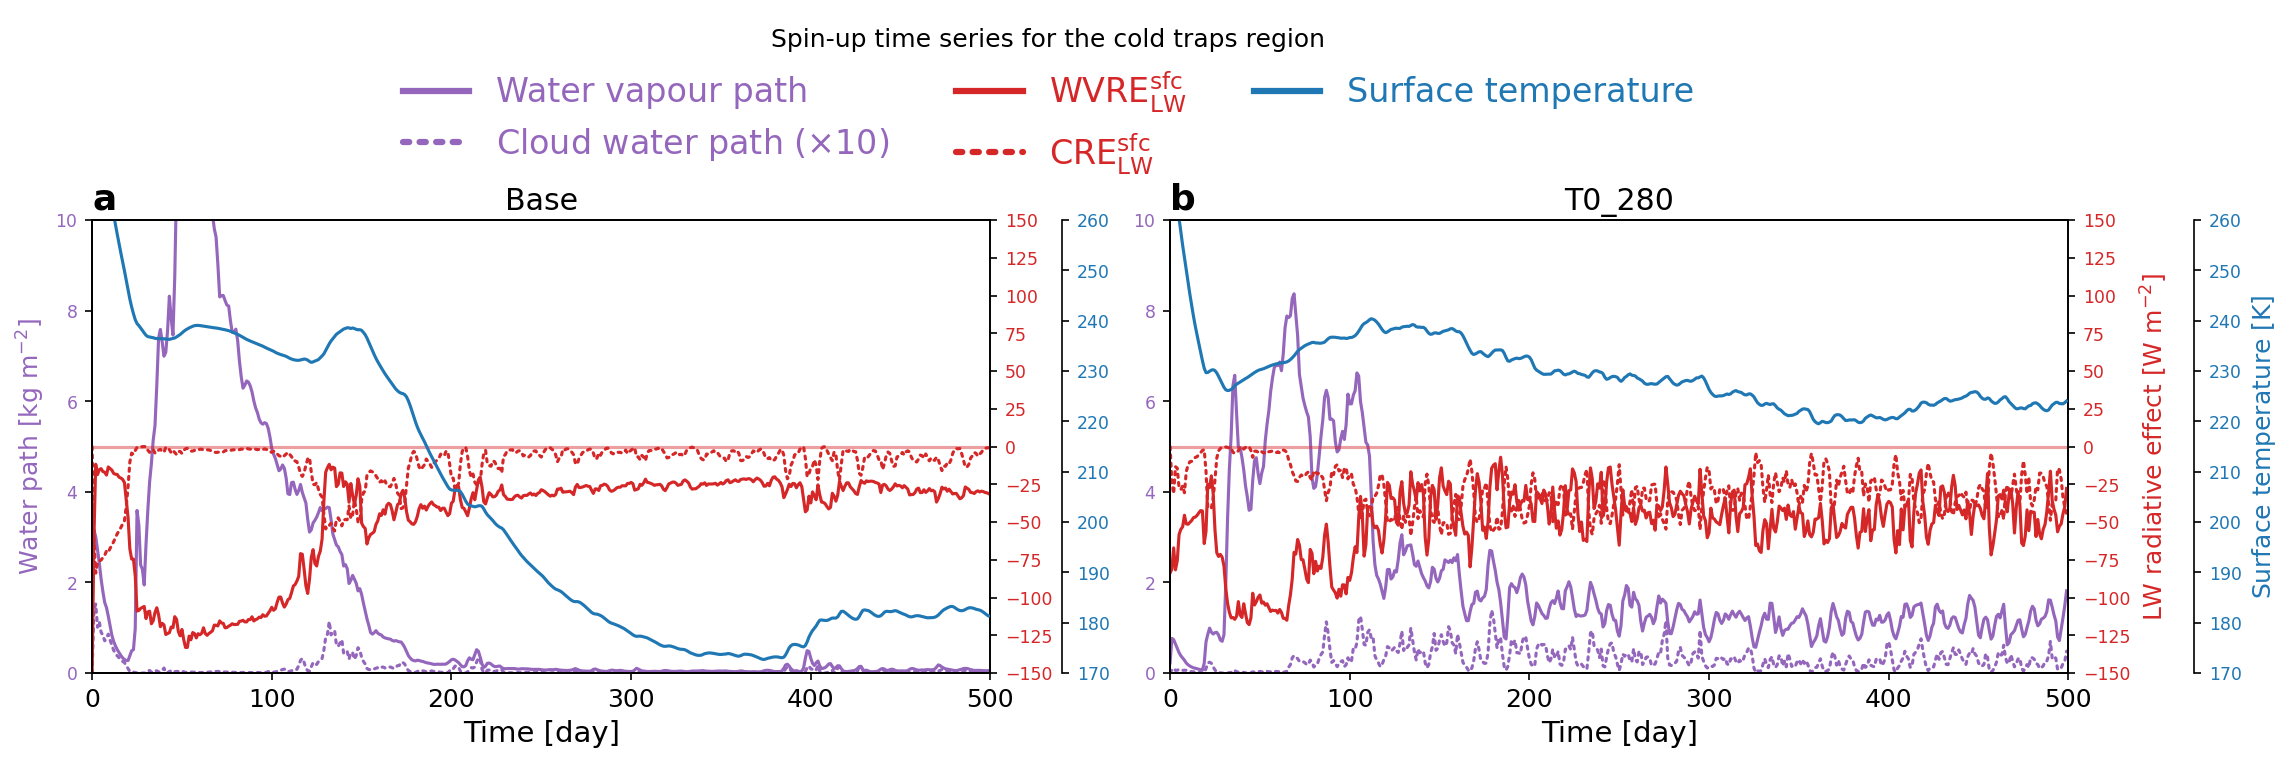

In [16]:
imgname = f"{img_prefix}__{'_'.join(SIM_LABELS)}__{'_'.join(vrbls_to_show)}__cold_traps"
xlim = [0, 500]
ncols = 2
nrows = 1
window = 10
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 8.5, nrows * 4))
iletters = subplot_label_generator()
for sim_label, ax in zip(SIM_LABELS.keys(), axs.flat):
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    ax.set_title(SIM_LABELS[sim_label]["title"], **KW_MAIN_TTL)
    ax.set_xlabel("Time [day]")
    n_axes = len(set([VRBL_PLOT[vrbl_key].get("ax", 0) for vrbl_key in vrbls_to_show]))
    twinx_axes = [ax]
    for _ in range(n_axes - 1):
        twinx_axes.append(ax.twinx())
    if len(twinx_axes) >= 3:
        for i, ax in enumerate(twinx_axes[2:]):
            if ax.is_last_col():
                x_off = 1.14 + i * 0.05
            else:
                x_off = 1.08 + i * 0.05
            ax.spines["right"].set_position(("axes", x_off))

    for i, vrbl_key in enumerate(vrbls_to_show):
        vrbl_prop = VRBL_PLOT[vrbl_key]
        if vrbl_prop.get("source", "") == "p":
            the_run = runs_p[sim_label]
        else:
            the_run = runs[sim_label]
        # Calculate diagnostics
        cube = RESULTS[sim_label][vrbl_key]
        # cube_rm = rolling_mean(cube, um.t, window=window)
        # Plot diagnostics
        _ax = twinx_axes[vrbl_prop.get("ax", 0)]

        if (_ax.is_first_col() and (vrbl_prop.get("ax", 0) == 0)) or (
            not _ax.is_first_col() and (vrbl_prop.get("ax", 0) != 0)
        ):
            _ax.set_ylabel(
                f'{vrbl_prop.get("ylabel", vrbl_prop["title"])} [{vrbl_prop["tex_units"]}]',
                color=vrbl_prop["kw_plt"]["color"],
                fontsize="medium",
            )
        _ax.set_ylim(vrbl_prop["lim"])
        if "ticks" in vrbl_prop:
            _ax.set_yticks(vrbl_prop["ticks"])
        _ax.set_xlim(xlim)
        if min(vrbl_prop["lim"]) < 0 and max(vrbl_prop["lim"]) > 0:
            _ax.hlines(0, *xlim, alpha=0.25, color=vrbl_prop["kw_plt"]["color"])
        _ax.tick_params(
            axis="y", labelcolor=vrbl_prop["kw_plt"]["color"], labelsize="x-small"
        )
        _ax.plot(
            get_cube_rel_days(cube),
            cube.data,  # cube_rm
            linewidth=1.5,
            **vrbl_prop["kw_plt"],
            label=vrbl_prop["title"],
        )
add_custom_legend(
    fig,
    {
        VRBL_PLOT[vrbl_key]["title"]: {"linewidth": 3, **VRBL_PLOT[vrbl_key]["kw_plt"]}
        for vrbl_key in vrbls_to_show
    },
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    frameon=False,
    ncol=3,
    title="Spin-up time series for the cold traps region",
)
# figsave(fig, plotdir / imgname)

---

In [41]:
vrbl_key = "wvp"
day_start = 300
day_end = 500
day_constr = iris.Constraint(**{um.fcst_prd: lambda x: day_start <= x.point / 24 <= day_end})
for sim_label in SIM_LABELS.keys():
    # cube_mean = time_mean(spatial_mean(runs[sim_label][vrbl_key].extract(cold_traps & day_constr)))
    cube_mean = time_mean(RESULTS[sim_label][vrbl_key].extract(day_constr))
    print(sim_label)
    print(f"{vrbl_key}: {float(cube_mean.data):.1f}")
    print()

base
wvp: 0.1

sens-t280k
wvp: 1.1



In [44]:
for sim_label in tqdm(SIM_LABELS.keys()):
    the_run = runs[sim_label]
    #         RESULTS[f"{suite_label}_{opt_label}"]["toa_olr"] = spatial_mean(
    #             the_run.toa_olr.extract(cold_traps)
    #         )
    RESULTS[sim_label]["sfc_dn_lw"] = spatial_mean(
        the_run.sfc_dn_lw.extract(cold_traps)
    )

  0%|          | 0/2 [00:00<?, ?it/s]

In [45]:
for sim_label in SIM_LABELS.keys():
    total = time_mean(
        extract_last_n_days(RESULTS[sim_label]["sfc_dn_lw"], 300)
    )
    print(f"{float(total.data):.1f}")
    for vrbl_key in ["wvre_lw_sfc", "cre_lw_sfc"]:
        cube = RESULTS[sim_label][vrbl_key]
        print(vrbl_key)
        cube_mean = time_mean(extract_last_n_days(cube, 300))
        print(f"Absolute: {float(cube_mean.data):.1f}")
        print(f"Relative: {float((cube_mean / total).data):.1%}")
        print()

55.6
wvre_lw_sfc
Absolute: -28.3
Relative: -50.9%

cre_lw_sfc
Absolute: -6.7
Relative: -12.1%

138.3
wvre_lw_sfc
Absolute: -43.5
Relative: -31.4%

cre_lw_sfc
Absolute: -30.9
Relative: -22.4%



## Habitability metric

In [62]:
def calc_ocean_frac(t_sfc, t_freeze=271.35):
    """Calculate the open ocean fraction from the UM dataset."""
    import dask.array as da

    ocean_frac = da.exp(-(t_freeze - t_sfc.core_data()) / 2)
    ocean_frac[ocean_frac > 1] = 1.0
    ocean_frac_cube = t_sfc.copy(data=ocean_frac)
    ocean_frac_cube.units = "1"
    ocean_frac_cube.rename("open_ocean_fraction")
    return ocean_frac_cube

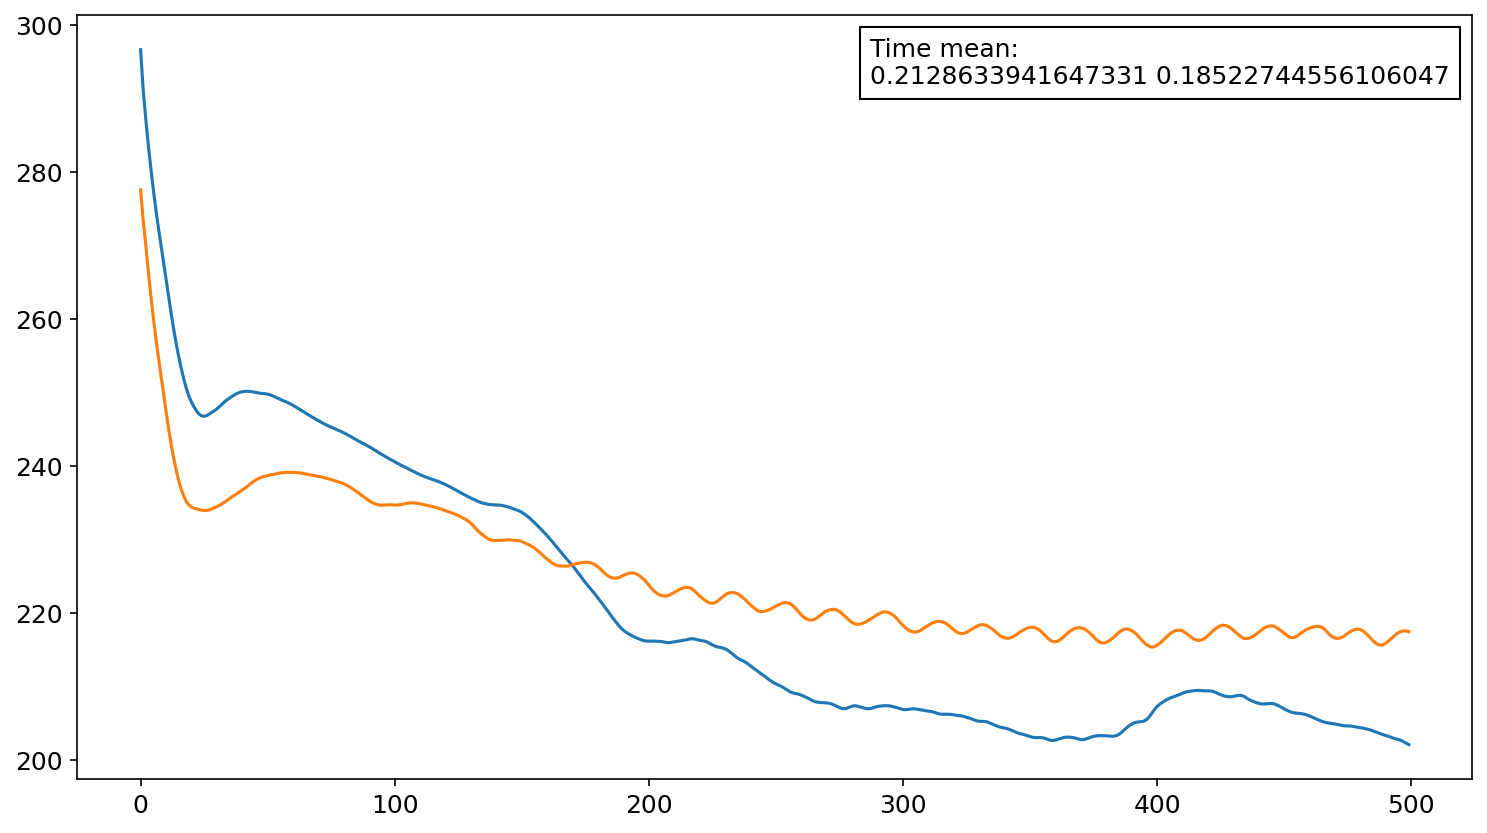

In [74]:
ax = plt.axes()
day_start = 300
day_end = 500
tmeans = []
for sim_label in SIM_LABELS:
    cube = spatial(calc_ocean_frac(runs[sim_label].t_sfc), "sum")

    # ax.plot(get_cube_rel_days(cube), cube.data)
    ax.plot(get_cube_rel_days(cube), spatial_mean(runs[sim_label].t_sfc.extract(NIGHTSIDE.constraint)).data)
    tmeans.append(
        time_mean(
            cube.extract(
                iris.Constraint(
                    **{um.fcst_prd: lambda x: day_start <= x.point / 24 <= day_end}
                )
            )
        )
    )
ax.add_artist(
    AnchoredText(f"Time mean:\n{' '.join([str(float(i.data)) for i in tmeans])}", loc="upper right")
)